<a href="https://colab.research.google.com/github/Krishnaqwerty/Stock_Price_Prediction_Using_RNN_LSTM_GRU_StackedLSTM/blob/main/ClothingPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import yfinance as yf

# Task
Compare the stock price prediction performance of RNN, LSTM, and GRU models on 15 years of Nifty 50 data from Yahoo Finance, and visualize the actual vs. predicted prices for each model.

## Fetch data

### Subtask:
Download 15 years of historical Nifty 50 stock data using `yfinance`.


**Reasoning**:
Define the ticker, calculate the start and end dates, download the data using yfinance, and display the head and info of the dataframe.



In [3]:
import pandas as pd
from datetime import date, timedelta

ticker = '^NSEI'
end_date = date.today()
start_date = end_date - timedelta(days=15*365)

nifty_data = yf.download(ticker, start=start_date, end=end_date)

display(nifty_data.head())
display(nifty_data.info())

/tmp/ipython-input-1389668977.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2010-11-01,6117.549805,6132.399902,6084.750000,6092.299805,0
2010-11-02,6119.000000,6138.100098,6094.399902,6127.549805,0
2010-11-03,6160.500000,6182.500000,6146.799805,6150.600098,0
2010-11-04,6281.799805,6290.149902,6199.350098,6209.600098,0
2010-11-08,6273.200195,6335.899902,6265.350098,6335.250000,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3676 entries, 2010-11-01 to 2025-10-27
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^NSEI)   3676 non-null   float64
 1   (High, ^NSEI)    3676 non-null   float64
 2   (Low, ^NSEI)     3676 non-null   float64
 3   (Open, ^NSEI)    3676 non-null   float64
 4   (Volume, ^NSEI)  3676 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 172.3 KB


None

## Preprocess data

### Subtask:
Prepare the data for the RNN models. This includes scaling, splitting into training and testing sets, and creating sequences for time series forecasting.


**Reasoning**:
Prepare the data for RNN models by scaling, splitting, and creating sequences as per the instructions.



In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Select the 'Close' price column and convert to NumPy array
close_price = nifty_data['Close'].values

# 2. Reshape the data
close_price = close_price.reshape(-1, 1)

# 3. & 4. Instantiate and apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price)

# 5. Split data into training and testing sets
training_data_len = int(np.ceil(len(scaled_data) * .80))
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :] # Use 60 previous days for testing as well

# 6. Create sequence creation function
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# 7. Apply sequence creation function to training and testing sets
sequence_length = 60
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

# 8. Reshape input sequences for RNN
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 9. Verify the shapes
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (2881, 60, 1)
Shape of y_train: (2881,)
Shape of x_test: (735, 60, 1)
Shape of y_test: (735,)


## Build and train models

### Subtask:
Construct and train the RNN, LSTM, and GRU models using the preprocessed data.


**Reasoning**:
Import necessary libraries and define functions to create and compile the RNN, LSTM, and GRU models. Then, create instances of these models and train them using the prepared training data.



In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

# Define a function to create and compile the RNN model
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=input_shape))
    model.add(SimpleRNN(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define a function to create and compile the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define a function to create and compile the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(GRU(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create instances of the models
rnn_model = build_rnn_model(input_shape=(sequence_length, 1))
lstm_model = build_lstm_model(input_shape=(sequence_length, 1))
gru_model = build_gru_model(input_shape=(sequence_length, 1))

# Train the models
print("Training RNN model...")
rnn_history = rnn_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), verbose=1)

print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), verbose=1)

print("\nTraining GRU model...")
gru_history = gru_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), verbose=1)

print("\nTraining complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN model...
Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0189 - val_loss: 0.0100
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.7634e-04 - val_loss: 0.0055
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.6590e-04 - val_loss: 0.0055
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.2934e-04 - val_loss: 0.0048
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.1251e-04 - val_loss: 0.0033
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.2105e-04 - val_loss: 0.0033
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.2329e-04 - val_loss: 0.0023
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.7782e-05 - val_loss: 0.0019
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.1357e-04 - val_loss: 0.0016
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.3464e-05 - val_loss: 0.0055
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.9838e-04 - val_loss: 0.0021
E

## Make Predictions

### Subtask:
Generate predictions for the test set using each trained model.

**Reasoning**:
Use the trained RNN, LSTM, and GRU models to predict stock prices on the `x_test` data.

In [6]:
# Make predictions
rnn_predictions = rnn_model.predict(x_test)
lstm_predictions = lstm_model.predict(x_test)
gru_predictions = gru_model.predict(x_test)

# Since the data was scaled, we need to inverse transform the predictions
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)

# Also inverse transform the actual test data for plotting
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Predictions generated.")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Predictions generated.


## Evaluate and Visualize

### Subtask:
Evaluate the performance of each model and plot the actual vs. predicted stock prices for comparison.

**Reasoning**:
Calculate evaluation metrics (e.g., RMSE) for each model and then create plots to visualize the actual stock prices against the predictions from each of the RNN, LSTM, and GRU models.

RNN RMSE: 266.30
LSTM RMSE: 225.53
GRU RMSE: 178.61


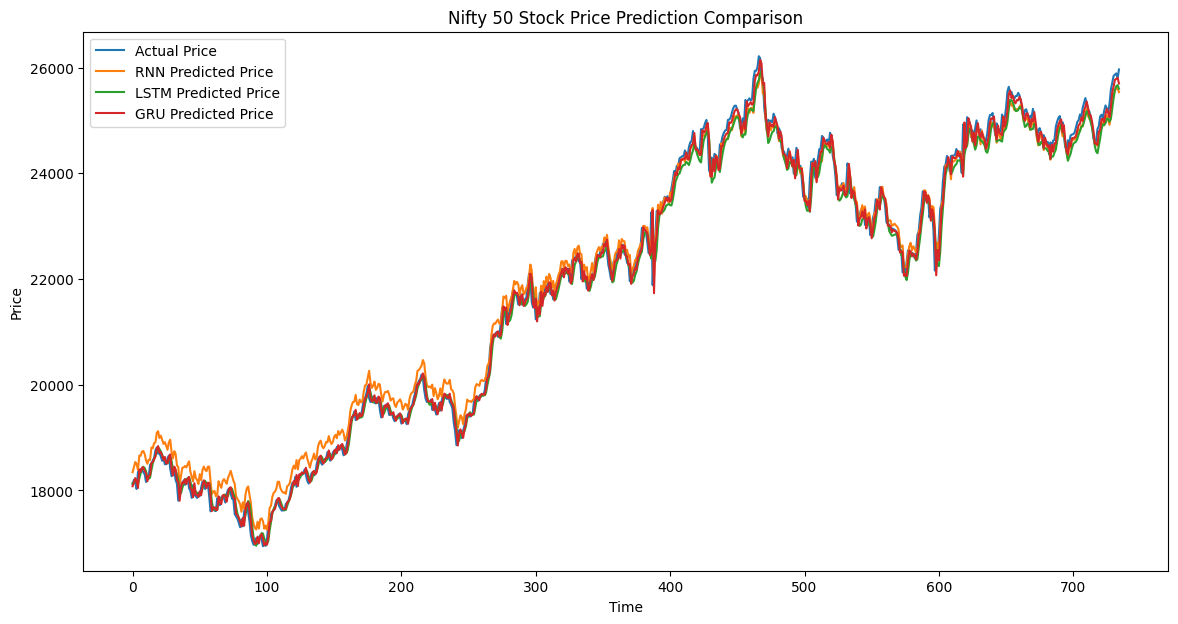

In [7]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calculate RMSE
rnn_rmse = np.sqrt(mean_squared_error(y_test_actual, rnn_predictions))
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_predictions))

print(f"RNN RMSE: {rnn_rmse:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"GRU RMSE: {gru_rmse:.2f}")

# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(rnn_predictions, label='RNN Predicted Price')
plt.plot(lstm_predictions, label='LSTM Predicted Price')
plt.plot(gru_predictions, label='GRU Predicted Price')
plt.title('Nifty 50 Stock Price Prediction Comparison')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Make Predictions for Last 30 Days

### Subtask:
Generate predictions for the last 30 days of the test set using each trained model.

**Reasoning**:
Use the trained RNN, LSTM, and GRU models to predict stock prices specifically for the last 30 days of the test data.

In [8]:
# Select the last 30 days of x_test for prediction
x_test_last_30_days = x_test[-30:]

# Make predictions for the last 30 days
rnn_predictions_last_30 = rnn_model.predict(x_test_last_30_days)
lstm_predictions_last_30 = lstm_model.predict(x_test_last_30_days)
gru_predictions_last_30 = gru_model.predict(x_test_last_30_days)

# Inverse transform the predictions and actual data for the last 30 days
rnn_predictions_last_30 = scaler.inverse_transform(rnn_predictions_last_30)
lstm_predictions_last_30 = scaler.inverse_transform(lstm_predictions_last_30)
gru_predictions_last_30 = scaler.inverse_transform(gru_predictions_last_30)
y_test_actual_last_30 = y_test_actual[-30:]

print("Predictions for the last 30 days generated.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predictions for the last 30 days generated.


## Visualize Predictions for Last 30 Days

### Subtask:
Plot the actual vs. predicted stock prices for the last 30 days, including dates on the x-axis.

**Reasoning**:
Create a plot to visualize the actual stock prices for the last 30 days against the predictions from each of the RNN, LSTM, and GRU models, using the corresponding dates.

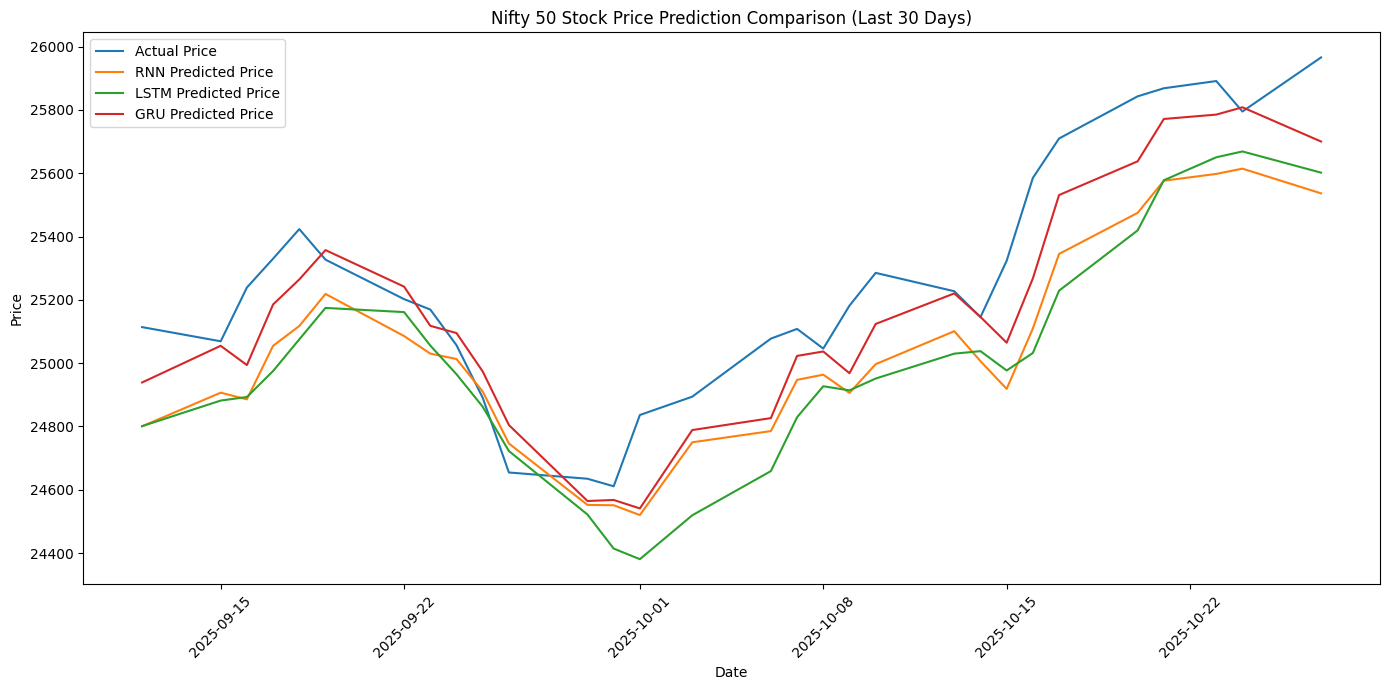

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the dates for the last 30 days of the test set
# The test data starts at index training_data_len + sequence_length in the original data
test_dates = nifty_data.index[training_data_len + sequence_length :]
last_30_dates = test_dates[-30:]

# Visualize the results for the last 30 days
plt.figure(figsize=(14, 7))
plt.plot(last_30_dates, y_test_actual_last_30, label='Actual Price')
plt.plot(last_30_dates, rnn_predictions_last_30, label='RNN Predicted Price')
plt.plot(last_30_dates, lstm_predictions_last_30, label='LSTM Predicted Price')
plt.plot(last_30_dates, gru_predictions_last_30, label='GRU Predicted Price')
plt.title('Nifty 50 Stock Price Prediction Comparison (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predict Today's Price

### Subtask:
Predict today's stock price using the trained models.

**Reasoning**:
Fetch the latest data, prepare it as input for the models, and then use the trained RNN, LSTM, and GRU models to predict today's closing price.

In [10]:
# Get the last 'sequence_length' days of data from the original nifty_data
last_sequence_data = scaled_data[-sequence_length:]

# Reshape the data to match the model input shape
last_sequence_data = np.reshape(last_sequence_data, (1, sequence_length, 1))

# Make predictions for today
rnn_prediction_today = rnn_model.predict(last_sequence_data)
lstm_prediction_today = lstm_model.predict(last_sequence_data)
gru_prediction_today = gru_model.predict(last_sequence_data)

# Inverse transform the predictions
rnn_prediction_today = scaler.inverse_transform(rnn_prediction_today)
lstm_prediction_today = scaler.inverse_transform(lstm_prediction_today)
gru_prediction_today = scaler.inverse_transform(gru_prediction_today)

print(f"RNN Predicted Price for Today: {rnn_prediction_today[0][0]:.2f}")
print(f"LSTM Predicted Price for Today: {lstm_prediction_today[0][0]:.2f}")
print(f"GRU Predicted Price for Today: {gru_prediction_today[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
RNN Predicted Price for Today: 25717.27
LSTM Predicted Price for Today: 25644.37
GRU Predicted Price for Today: 25897.73


In [12]:
# Get the actual closing price for the most recent date
actual_price_today = nifty_data['Close'].iloc[-1]

print(f"Actual Closing Price for the most recent date: {actual_price_today.iloc[0]:.2f}")

Actual Closing Price for the most recent date: 25966.05


## Build and Train Stacked LSTM Model

### Subtask:
Construct and train a stacked LSTM model using the preprocessed data.

**Reasoning**:
Define a function to create and compile the stacked LSTM model with multiple LSTM layers and dropout, and then train it using the prepared training data with early stopping.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define a function to create and compile the stacked LSTM model
def build_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create an instance of the stacked LSTM model
stacked_lstm_model = build_stacked_lstm_model(input_shape=(sequence_length, 1))

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the stacked LSTM model
print("Training Stacked LSTM model...")
stacked_lstm_history = stacked_lstm_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100, # Set a higher number of epochs and rely on early stopping
    validation_data=(x_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

print("\nTraining complete.")

Training Stacked LSTM model...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - loss: 0.0108 - val_loss: 0.0031
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 8.3211e-04 - val_loss: 4.6115e-04
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - loss: 9.4980e-04 - val_loss: 0.0012
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - loss: 0.0012 - val_loss: 0.0066
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - loss: 7.2535e-04 - val_loss: 4.5118e-04
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 7.7251e-04 - val_loss: 0.0014
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 5.6507e-04 - val_loss: 8.9218e-04
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 5.8153e-04 - val_loss: 0.0195
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - loss: 0.0024 - val_loss: 4.7858e-04
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 6.8934e-04 - val_loss: 3.7019e-04
Epoch 11/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 6.5229e-04 - val_los

## Make Predictions with Stacked LSTM for Last 30 Days

### Subtask:
Generate predictions for the last 30 days of the test set using the trained stacked LSTM model.

**Reasoning**:
Use the trained stacked LSTM model to predict stock prices specifically for the last 30 days of the test data.

In [14]:
# Select the last 30 days of x_test for prediction
x_test_last_30_days = x_test[-30:]

# Make predictions for the last 30 days using the stacked LSTM model
stacked_lstm_predictions_last_30 = stacked_lstm_model.predict(x_test_last_30_days)

# Inverse transform the stacked LSTM predictions
stacked_lstm_predictions_last_30 = scaler.inverse_transform(stacked_lstm_predictions_last_30)

print("Predictions for the last 30 days using Stacked LSTM generated.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Predictions for the last 30 days using Stacked LSTM generated.


## Visualize Stacked LSTM Predictions for Last 30 Days

### Subtask:
Plot the actual vs. stacked LSTM predicted stock prices for the last 30 days, including dates on the x-axis, and compare with simple LSTM predictions.

**Reasoning**:
Create a plot to visualize the actual stock prices for the last 30 days against the predictions from the stacked LSTM and simple LSTM models, using the corresponding dates.

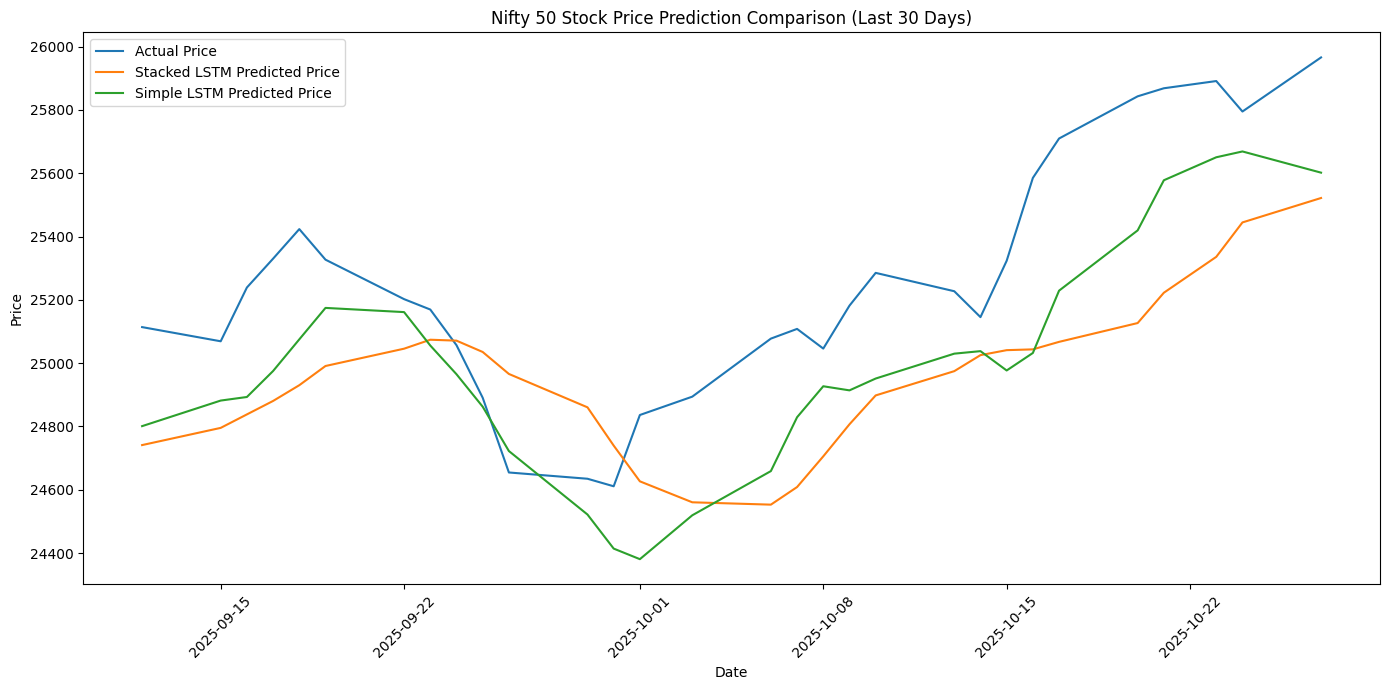

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the dates for the last 30 days of the test set
# The test data starts at index training_data_len + sequence_length in the original data
test_dates = nifty_data.index[training_data_len + sequence_length :]
last_30_dates = test_dates[-30:]

# Visualize the results for the last 30 days, including stacked LSTM and simple LSTM
plt.figure(figsize=(14, 7))
plt.plot(last_30_dates, y_test_actual_last_30, label='Actual Price')
plt.plot(last_30_dates, stacked_lstm_predictions_last_30, label='Stacked LSTM Predicted Price')
plt.plot(last_30_dates, lstm_predictions_last_30, label='Simple LSTM Predicted Price') # Using lstm_predictions_last_30 from earlier
plt.title('Nifty 50 Stock Price Prediction Comparison (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()